# Predicting Sepsis Using MIMIC-III Data
Giovanna Graciani

## Problem Statement
Predict sepsis in ICU. Sepsis = {1 (Yes), 0 (No)}


In [79]:
import sys
import pandas as pd
import os
import numpy as np
import sqlalchemy
import pymysql
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score
from sklearn import model_selection
import seaborn as sns
import matplotlib.pyplot as plt
import dateutil
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

MIMIC_DIR = "mimic3/"

In [2]:
icu_stays = pd.read_csv(MIMIC_DIR + "ICUSTAYS.csv")
admissions_data = pd.read_csv(MIMIC_DIR+ "ADMISSIONS.csv")
drg_codes = pd.read_csv(MIMIC_DIR+"DRGCODES.csv")
patients  = pd.read_csv(MIMIC_DIR + "PATIENTS.csv")

In [3]:
l = "_left"
r = "_right"

admit_patient_icu_stays = pd.merge(admissions_data, patients, on="SUBJECT_ID", suffixes=("_admit", "_patient"))
admit_patient_icu_stays = pd.merge(admit_patient_icu_stays, icu_stays, on="HADM_ID", suffixes=("_admit", "_icu"))

# Compute age on date of admission
admit_patient_icu_stays["DOB"] = pd.to_datetime(admit_patient_icu_stays["DOB"]) 
#admit_patient_icu_stays["AGE"] = abs(admit_patient_icu_stays["ADMITTIME"] - admit_patient_icu_stays["DOB"])
#admit_patient_icu_stays["AGE"] = pd.to_numeric(admit_patient_icu_stays["AGE"].dt.days // 365)
admit_patient_icu_stays.head(25)
data = pd.merge(admit_patient_icu_stays, drg_codes, on="HADM_ID")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131852 entries, 0 to 131851
Data columns (total 44 columns):
ROW_ID_admit            131852 non-null int64
SUBJECT_ID_admit        131852 non-null int64
HADM_ID                 131852 non-null int64
ADMITTIME               131852 non-null object
DISCHTIME               131852 non-null object
DEATHTIME               14359 non-null object
ADMISSION_TYPE          131852 non-null object
ADMISSION_LOCATION      131852 non-null object
DISCHARGE_LOCATION      131852 non-null object
INSURANCE               131852 non-null object
LANGUAGE                96765 non-null object
RELIGION                131372 non-null object
MARITAL_STATUS          115436 non-null object
ETHNICITY               131852 non-null object
EDREGTIME               75892 non-null object
EDOUTTIME               75892 non-null object
DIAGNOSIS               131850 non-null object
HOSPITAL_EXPIRE_FLAG    131852 non-null int64
HAS_CHARTEVENTS_DATA    131852 non-null int64
ROW_I

In [5]:
data.head()

,ROW_ID_admit,SUBJECT_ID_admit,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,INTIME,OUTTIME,LOS,ROW_ID_y,SUBJECT_ID,DRG_TYPE,DRG_CODE,DESCRIPTION,DRG_SEVERITY,DRG_MORTALITY
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,...,2196-04-09 12:27:00,2196-04-10 15:54:00,1.1438,4121,22,HCFA,450,POISONING & TOXIC EFFECTS OF DRUGS AGE >17 WIT...,NaN,NaN
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,...,2153-09-03 09:38:55,2153-09-04 15:59:11,1.2641,17916,23,HCFA,109,CORONARY BYPASS WITHOUT CARDIAC CATHETER,NaN,NaN
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,2157-10-21 11:40:38,2157-10-22 16:08:48,1.1862,75333,23,MS,25,CRANIOTOMY & ENDOVASCULAR INTRACRANIAL PROCEDU...,NaN,NaN
3,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,2157-10-21 11:40:38,2157-10-22 16:08:48,1.1862,75231,23,APR,212,Craniotomy Except for Trauma,2.0,3.0
4,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,...,2157-10-21 11:40:38,2157-10-22 16:08:48,1.1862,75232,23,APR,212,Craniotomy Except for Trauma,2.0,3.0


In [6]:
data['FIRST_CAREUNIT'].value_counts()

MICU     48027
SICU     21261
CSRU     19609
CCU      16038
TSICU    14821
NICU     12096
Name: FIRST_CAREUNIT, dtype: int64

In [7]:
data = data[data.FIRST_CAREUNIT != 'NICU']

In [8]:
data['FIRST_CAREUNIT'].value_counts()

MICU     48027
SICU     21261
CSRU     19609
CCU      16038
TSICU    14821
Name: FIRST_CAREUNIT, dtype: int64

In [9]:
data['DRG_CODE'].value_counts()

7204    3281
1662    1401
871     1294
1633    1115
105     1044
14       983
44       957
416      873
107      873
475      859
1632     841
236      818
1334     812
443      806
7104     803
54       762
7203     722
1943     716
109      713
174      705
1304     663
1653     662
4603     649
208      637
110      637
1663     625
213      619
25       598
1        587
1374     586
        ... 
2431       1
266        1
4452       1
505        1
6601       1
714        1
7731       1
4801       1
749        1
5173       1
3052       1
4441       1
4843       1
741        1
712        1
361        1
911        1
655        1
935        1
718        1
4812       1
686        1
142        1
734        1
8501       1
671        1
160        1
119        1
5451       1
458        1
Name: DRG_CODE, Length: 1560, dtype: int64

# 1. Create Target variable

In [10]:
data['Sepsis'] = data['DRG_CODE'].apply(lambda x: 1 if (x == 871 or x == 870 or x == 872) else 0)

In [11]:
data['Sepsis'].value_counts()

0    118043
1      1713
Name: Sepsis, dtype: int64

# Baseline accuracy expected: 98.5%

In [12]:
print("Accuracy : ", round(1-(1713/118043),3))

Accuracy :  0.985


# 2. Data clean up

In [13]:
list(data)

['ROW_ID_admit',
 'SUBJECT_ID_admit',
 'HADM_ID',
 'ADMITTIME',
 'DISCHTIME',
 'DEATHTIME',
 'ADMISSION_TYPE',
 'ADMISSION_LOCATION',
 'DISCHARGE_LOCATION',
 'INSURANCE',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'ETHNICITY',
 'EDREGTIME',
 'EDOUTTIME',
 'DIAGNOSIS',
 'HOSPITAL_EXPIRE_FLAG',
 'HAS_CHARTEVENTS_DATA',
 'ROW_ID_patient',
 'GENDER',
 'DOB',
 'DOD',
 'DOD_HOSP',
 'DOD_SSN',
 'EXPIRE_FLAG',
 'ROW_ID_x',
 'SUBJECT_ID_icu',
 'ICUSTAY_ID',
 'DBSOURCE',
 'FIRST_CAREUNIT',
 'LAST_CAREUNIT',
 'FIRST_WARDID',
 'LAST_WARDID',
 'INTIME',
 'OUTTIME',
 'LOS',
 'ROW_ID_y',
 'SUBJECT_ID',
 'DRG_TYPE',
 'DRG_CODE',
 'DESCRIPTION',
 'DRG_SEVERITY',
 'DRG_MORTALITY',
 'Sepsis']

In [14]:
data = data.drop(['ROW_ID_admit','HADM_ID', 'DBSOURCE', 'ICUSTAY_ID',
                  'SUBJECT_ID','HAS_CHARTEVENTS_DATA', 'DESCRIPTION', 'ADMISSION_TYPE','EDREGTIME','EDOUTTIME','DRG_TYPE', 'OUTTIME', 'LAST_WARDID', 'DISCHARGE_LOCATION', 'LAST_CAREUNIT','DISCHTIME','DEATHTIME'],axis=1)

In [15]:
data=data.drop(['ROW_ID_y', 'DRG_MORTALITY', 'DRG_SEVERITY','SUBJECT_ID_icu', 'ROW_ID_x', 'DOD_SSN', 'DOD_HOSP', 'DOD', 'ROW_ID_patient','EXPIRE_FLAG', 'HOSPITAL_EXPIRE_FLAG', 'SUBJECT_ID_admit'],axis=1)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119756 entries, 0 to 131851
Data columns (total 16 columns):
ADMITTIME             119756 non-null object
ADMISSION_LOCATION    119756 non-null object
INSURANCE             119756 non-null object
LANGUAGE              96117 non-null object
RELIGION              119285 non-null object
MARITAL_STATUS        114880 non-null object
ETHNICITY             119756 non-null object
DIAGNOSIS             119754 non-null object
GENDER                119756 non-null object
DOB                   119756 non-null datetime64[ns]
FIRST_CAREUNIT        119756 non-null object
FIRST_WARDID          119756 non-null int64
INTIME                119756 non-null object
LOS                   119753 non-null float64
DRG_CODE              119756 non-null int64
Sepsis                119756 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(3), object(11)
memory usage: 15.5+ MB


In [17]:
data['Sepsis'].value_counts()

0    118043
1      1713
Name: Sepsis, dtype: int64

In [18]:
data['ADMITTIME'] = pd.to_datetime(data['ADMITTIME'])
data['Age'] = abs(data["ADMITTIME"] - data["DOB"])
data['Age'] = pd.to_numeric(data["Age"].dt.days // 365)

In [19]:
data.head()

,ADMITTIME,ADMISSION_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,GENDER,DOB,FIRST_CAREUNIT,FIRST_WARDID,INTIME,LOS,DRG_CODE,Sepsis,Age
0,2196-04-09 12:26:00,EMERGENCY ROOM ADMIT,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,BENZODIAZEPINE OVERDOSE,F,2131-05-07,MICU,52,2196-04-09 12:27:00,1.1438,450,0,64
1,2153-09-03 07:15:00,PHYS REFERRAL/NORMAL DELI,Medicare,NaN,CATHOLIC,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,M,2082-07-17,CSRU,14,2153-09-03 09:38:55,1.2641,109,0,71
2,2157-10-18 19:34:00,TRANSFER FROM HOSP/EXTRAM,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,BRAIN MASS,M,2082-07-17,SICU,57,2157-10-21 11:40:38,1.1862,25,0,75
3,2157-10-18 19:34:00,TRANSFER FROM HOSP/EXTRAM,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,BRAIN MASS,M,2082-07-17,SICU,57,2157-10-21 11:40:38,1.1862,212,0,75
4,2157-10-18 19:34:00,TRANSFER FROM HOSP/EXTRAM,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,BRAIN MASS,M,2082-07-17,SICU,57,2157-10-21 11:40:38,1.1862,212,0,75


In [20]:
data.loc[data['DIAGNOSIS'].str.contains("SEP", na=False),'Diagnosis_Flag'] = '1'
data['Diagnosis_Flag'] = data['Diagnosis_Flag'].fillna(0)
data.drop(['DIAGNOSIS'], axis =1)

,ADMITTIME,ADMISSION_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,DOB,FIRST_CAREUNIT,FIRST_WARDID,INTIME,LOS,DRG_CODE,Sepsis,Age,Diagnosis_Flag
0,2196-04-09 12:26:00,EMERGENCY ROOM ADMIT,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,F,2131-05-07,MICU,52,2196-04-09 12:27:00,1.1438,450,0,64,0
1,2153-09-03 07:15:00,PHYS REFERRAL/NORMAL DELI,Medicare,NaN,CATHOLIC,MARRIED,WHITE,M,2082-07-17,CSRU,14,2153-09-03 09:38:55,1.2641,109,0,71,0
2,2157-10-18 19:34:00,TRANSFER FROM HOSP/EXTRAM,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,2082-07-17,SICU,57,2157-10-21 11:40:38,1.1862,25,0,75,0
3,2157-10-18 19:34:00,TRANSFER FROM HOSP/EXTRAM,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,2082-07-17,SICU,57,2157-10-21 11:40:38,1.1862,212,0,75,0
4,2157-10-18 19:34:00,TRANSFER FROM HOSP/EXTRAM,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,M,2082-07-17,SICU,57,2157-10-21 11:40:38,1.1862,212,0,75,0
5,2139-06-06 16:14:00,TRANSFER FROM HOSP/EXTRAM,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,M,2100-05-31,CCU,7,2139-06-06 16:15:36,0.5124,526,0,39,0
6,2160-11-02 02:06:00,EMERGENCY ROOM ADMIT,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,M,2101-11-21,CCU,7,2160-11-02 03:16:23,3.5466,526,0,58,0
7,2126-05-06 15:16:00,TRANSFER FROM HOSP/EXTRAM,Medicare,NaN,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,M,2054-05-04,CCU,57,2126-05-07 09:52:30,2.1407,515,0,72,0
9,2177-09-01 07:15:00,PHYS REFERRAL/NORMAL DELI,Medicare,NaN,CATHOLIC,MARRIED,WHITE,M,2103-04-15,CSRU,14,2177-09-01 09:32:26,1.1224,109,0,74,0
10,2172-10-14 14:17:00,TRANSFER FROM HOSP/EXTRAM,Medicare,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,M,1872-10-14,CCU,57,2172-10-14 17:24:00,1.8472,468,0,284,0


In [21]:
data['Diagnosis_Flag'].value_counts()

0    115123
1      4633
Name: Diagnosis_Flag, dtype: int64

In [22]:
1-(4662/115094)

0.9594939788346917

In [23]:
data = data.drop(['DIAGNOSIS', 'DRG_CODE'],axis=1)

In [24]:
data['LOS'] = data['LOS'].fillna(0)
data['LOS'] = data['LOS'].apply(lambda x: round(x,0)).astype(int)

In [25]:
data['RELIGION'].value_counts()

CATHOLIC                  43692
NOT SPECIFIED             27238
PROTESTANT QUAKER         15721
UNOBTAINABLE              11147
JEWISH                    10980
OTHER                      4933
EPISCOPALIAN               1621
GREEK ORTHODOX             1004
CHRISTIAN SCIENTIST         811
BUDDHIST                    551
MUSLIM                      428
JEHOVAH'S WITNESS           296
UNITARIAN-UNIVERSALIST      265
ROMANIAN EAST. ORTH         194
HINDU                       180
7TH DAY ADVENTIST           167
BAPTIST                      28
HEBREW                       20
METHODIST                     8
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [26]:
data['Religion_Hindu'] = data['RELIGION'].apply(lambda x: 1 if (x=='HINDU') else 0)
data['Religion_Buddhist'] = data['RELIGION'].apply(lambda x: 1 if (x=='BUDDHIST') else 0)
data['Religion_Muslim'] = data['RELIGION'].apply(lambda x: 1 if (x=='MUSLIM') else 0)
data['Religion_Christian'] = data['RELIGION'].apply(lambda x: 1 if (x=='CATHOLIC' or x =='PREOTESTANT QUAKER' or x == 'EPISCOPALIAN' or x == 'GREEK ORTHODOX' or x == 'CHRISTIAN SCIENTIST' or x == "JEHOVAH'S WITNESS" or x == 'ROMANIAN EAST. ORTH' or x == '7TH DAY ADVENTIST' or x == 'BAPTIST' or x == 'JEWISH' or x =='HEBREW' or x=='METHODIST' or x =='LUTHERAN') else 0)

In [27]:
data['MARITAL_STATUS'].value_counts()

MARRIED              56367
SINGLE               31830
WIDOWED              16810
DIVORCED              7815
SEPARATED             1322
UNKNOWN (DEFAULT)      688
LIFE PARTNER            48
Name: MARITAL_STATUS, dtype: int64

In [28]:
data['Married'] = data['MARITAL_STATUS'].apply(lambda x: 1 if (x == 'MARRIED' or x =='LIFE PARTNER') else 0)
data['Widowed'] = data['MARITAL_STATUS'].apply(lambda x: 1 if (x == 'WIDOWED') else 0)
data['Single'] = data['MARITAL_STATUS'].apply(lambda x: 1 if (x == 'SEPARATED' or x == 'DIVORCED' or x == 'SINGLE') else 0)

In [29]:
data['Language_English'] = data['LANGUAGE'].apply(lambda x: 1 if x == 'ENGL' else 0)

In [30]:
data['ETHNICITY'].value_counts()

WHITE                                                       86224
BLACK/AFRICAN AMERICAN                                      10995
UNKNOWN/NOT SPECIFIED                                        6439
HISPANIC OR LATINO                                           3156
OTHER                                                        2664
UNABLE TO OBTAIN                                             2458
ASIAN                                                        1672
PATIENT DECLINED TO ANSWER                                   1018
ASIAN - CHINESE                                               682
HISPANIC/LATINO - PUERTO RICAN                                666
BLACK/CAPE VERDEAN                                            515
WHITE - RUSSIAN                                               483
BLACK/HAITIAN                                                 293
MULTI RACE ETHNICITY                                          271
ASIAN - ASIAN INDIAN                                          254
HISPANIC/L

White.
Hispanic or Latino.
Black or African American.
Native American or American Indian.
Asian / Pacific Islander.
Other.

In [31]:
data['Ethnicity_White'] = data['ETHNICITY'].apply(lambda x: 1 if (x=="WHITE" or x=='WHITE - RUSSIAN' or x =='WHITE - OTHER EUROPEAN' or x == 'WHITE - BRAZILIAN' or x=='WHITE - EASTERN EUROPEAN') else 0)
data['Ethnicity_HispanicLatino'] = data['ETHNICITY'].apply(lambda x: 1 if (x=='HISPANIC OR LATINO' or x =='HISPANIC/LATINO - PUERTO RICAN' or x == 'HISPANIC/LATINO - DOMINICAN' or x =='PORTUGUESE' or x =='HISPANIC/LATINO - GUATEMALAN' or x == 'HISPANIC/LATINO - CUBAN' or x == 'HISPANIC/LATINO - SALVADORAN' or x == 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)' or x == 'HISPANIC/LATINO - MEXICAN'or x == 'HISPANIC/LATINO - COLOMBIAN' or x=='CARIBBEAN ISLAND' or x=='HISPANIC/LATINO - HONDURAN' or x =='SOUTH AMERICAN')else 0)
data['Ethnicity_AfricanAmerican'] =  data['ETHNICITY'].apply(lambda x: 1 if (x=='BLACK/AFRICAN AMERICAN' or x =='BLACK/CAPE VERDEAN' or x =='BLACK/HAITIAN' or x =='BLACK/AFRICAN' ) else 0)
data['Ethnicity_NativeAmerican'] = data['ETHNICITY'].apply(lambda x: 1 if (x == 'AMERICAN INDIAN/ALASKA NATIVE' or x =='AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE ') else 0)
data['Ethnicity_AsianPacificIsl'] = data['ETHNICITY'].apply(lambda x: 1 if (x=='ASIAN' or x=='ASIAN - CHINESE' or x =='ASIAN - ASIAN INDIAN' or x == 'ASIAN - VIETNAMESE' or x=='ASIAN - FILIPINO' or x=='ASIAN - CAMBODIAN' or x=='ASIAN - OTHER' or x == 'ASIAN - KOREAN' or x =='ASIAN - JAPANESE' or x =='ASIAN - THAI' or x=='NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER') else 0)
data['Ethnicity_Other'] = data['ETHNICITY'].apply(lambda x: 1 if (x == 'OTHER' or x=='MULTI RACE ETHNICITY' or x=='MIDDLE EASTERN') else 0)

In [32]:
data = data.drop(['MARITAL_STATUS','RELIGION', 'ETHNICITY', 'LANGUAGE'], axis=1)

In [33]:
data = data.drop(['INTIME','ADMITTIME','DOB'],axis=1)

In [34]:
le = LabelEncoder()
data['FIRST_CAREUNIT'] = le.fit_transform(data['FIRST_CAREUNIT'])
data['ADMISSION_LOCATION'] = le.fit_transform(data['ADMISSION_LOCATION'])
data['INSURANCE'] = le.fit_transform(data['INSURANCE'])
data['GENDER'] = le.fit_transform(data['GENDER'])

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119756 entries, 0 to 131851
Data columns (total 23 columns):
ADMISSION_LOCATION           119756 non-null int64
INSURANCE                    119756 non-null int64
GENDER                       119756 non-null int64
FIRST_CAREUNIT               119756 non-null int64
FIRST_WARDID                 119756 non-null int64
LOS                          119756 non-null int64
Sepsis                       119756 non-null int64
Age                          119756 non-null int64
Diagnosis_Flag               119756 non-null object
Religion_Hindu               119756 non-null int64
Religion_Buddhist            119756 non-null int64
Religion_Muslim              119756 non-null int64
Religion_Christian           119756 non-null int64
Married                      119756 non-null int64
Widowed                      119756 non-null int64
Single                       119756 non-null int64
Language_English             119756 non-null int64
Ethnicity_White      

# 3. Data Exploration

#  Put histograms of data vs sepsis here **

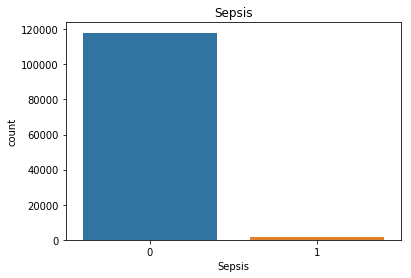

In [36]:
ns = sns.countplot(x=data.Sepsis)
ns.set_title("Sepsis")
plt.show()

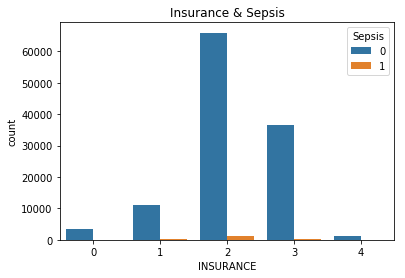

In [37]:
ns = sns.countplot(x=data.INSURANCE, hue=data.Sepsis)
ns.set_title("Insurance & Sepsis")
plt.show()

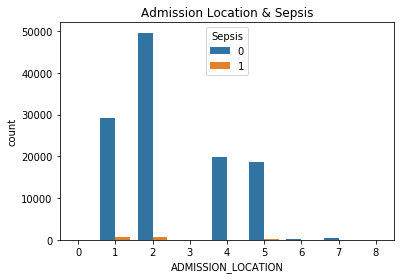

In [38]:
ns = sns.countplot(x=data.ADMISSION_LOCATION, hue=data.Sepsis)
ns.set_title("Admission Location & Sepsis")
plt.show()

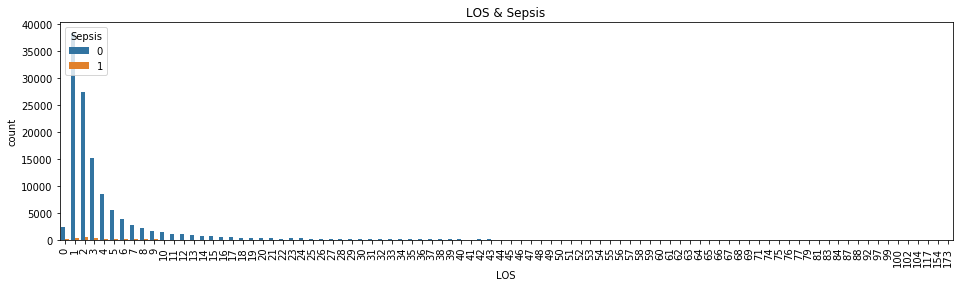

In [39]:
plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
ns = sns.countplot(x=data.LOS, hue=data.Sepsis)
ns.set_title("LOS & Sepsis")
plt.show()

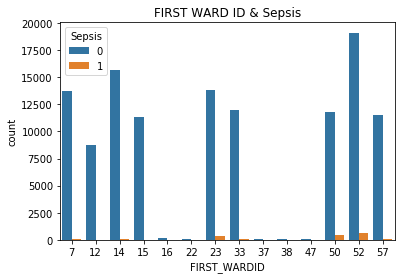

In [40]:
ns = sns.countplot(x=data.FIRST_WARDID , hue=data.Sepsis)
ns.set_title("FIRST WARD ID & Sepsis")
plt.show()

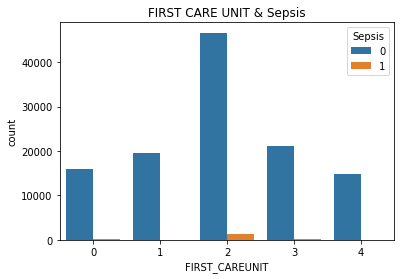

In [41]:
ns = sns.countplot(x=data.FIRST_CAREUNIT, hue=data.Sepsis)
ns.set_title("FIRST CARE UNIT & Sepsis")
plt.show()

In [42]:
y = data['Sepsis']  
X = data.drop(['Sepsis','Diagnosis_Flag'],axis=1)

In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119756 entries, 0 to 131851
Data columns (total 21 columns):
ADMISSION_LOCATION           119756 non-null int64
INSURANCE                    119756 non-null int64
GENDER                       119756 non-null int64
FIRST_CAREUNIT               119756 non-null int64
FIRST_WARDID                 119756 non-null int64
LOS                          119756 non-null int64
Age                          119756 non-null int64
Religion_Hindu               119756 non-null int64
Religion_Buddhist            119756 non-null int64
Religion_Muslim              119756 non-null int64
Religion_Christian           119756 non-null int64
Married                      119756 non-null int64
Widowed                      119756 non-null int64
Single                       119756 non-null int64
Language_English             119756 non-null int64
Ethnicity_White              119756 non-null int64
Ethnicity_HispanicLatino     119756 non-null int64
Ethnicity_AfricanAmeri

# 4. Identify Important Features

In [44]:
from sklearn.feature_selection import RFE
names = X.columns.values
logreg = LogisticRegression()
rfe=RFE(logreg)
rfe=rfe.fit(X, y)
print("Features sorted by rank:")
print(sorted(zip(map(lambda x: round(x,4), rfe.ranking_),names)))

Features sorted by rank:
[(1, 'ADMISSION_LOCATION'), (1, 'Ethnicity_AsianPacificIsl'), (1, 'Ethnicity_HispanicLatino'), (1, 'INSURANCE'), (1, 'Language_English'), (1, 'Religion_Buddhist'), (1, 'Religion_Christian'), (1, 'Religion_Hindu'), (1, 'Religion_Muslim'), (1, 'Widowed'), (2, 'GENDER'), (3, 'Ethnicity_NativeAmerican'), (4, 'Single'), (5, 'Ethnicity_White'), (6, 'FIRST_CAREUNIT'), (7, 'Ethnicity_Other'), (8, 'Ethnicity_AfricanAmerican'), (9, 'Married'), (10, 'FIRST_WARDID'), (11, 'LOS'), (12, 'Age')]


In [45]:
y2 = data['Sepsis']
X2 = data.drop(['Sepsis', 'GENDER', 'Ethnicity_NativeAmerican','Single','Ethnicity_White','FIRST_CAREUNIT','Ethnicity_Other','Ethnicity_AfricanAmerican','Married','FIRST_WARDID','LOS','Age'],axis=1)

In [46]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119756 entries, 0 to 131851
Data columns (total 11 columns):
ADMISSION_LOCATION           119756 non-null int64
INSURANCE                    119756 non-null int64
Diagnosis_Flag               119756 non-null object
Religion_Hindu               119756 non-null int64
Religion_Buddhist            119756 non-null int64
Religion_Muslim              119756 non-null int64
Religion_Christian           119756 non-null int64
Widowed                      119756 non-null int64
Language_English             119756 non-null int64
Ethnicity_HispanicLatino     119756 non-null int64
Ethnicity_AsianPacificIsl    119756 non-null int64
dtypes: int64(10), object(1)
memory usage: 16.0+ MB


# 5. Compare Model Results with all features vs top features

## Model results using 10-fold cross validation (all features)

In [47]:
models = []
results = []
names = []
scoring = 'roc_auc'#'accuracy'
seed = 7
models.append(('LR', LogisticRegression()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X2, y2, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%0.3f (+/- %0.3f)" % (name, cv_results.mean(), cv_results.std() * 2)
    print(msg)
    #print('\t Min recall:', round(cv_results.min(),3))
    #print('\t Max recall:', round(cv_results.max(),3))

LR:	0.732 (+/- 0.150)
ADA:	0.765 (+/- 0.129)
KNN:	0.563 (+/- 0.024)
CART:	0.740 (+/- 0.145)
NB:	0.734 (+/- 0.134)


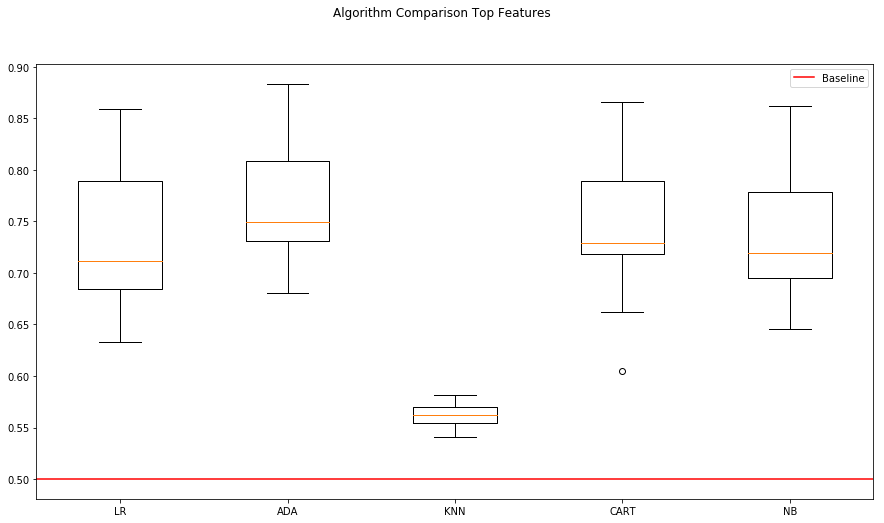

In [48]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,8))
fig.suptitle('Algorithm Comparison Top Features')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.axhline(y=0.5, color='r', linestyle='-',label='Baseline')
plt.legend()
plt.show()

## Model results using 10-fold cross validation (top 1 rank features)

In [49]:
models = []
results = []
names = []
scoring = 'accuracy'
seed = 7
models.append(('LR', LogisticRegression()))
models.append(('ADA', AdaBoostClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X2, y2, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%0.3f (+/- %0.3f)" % (name, cv_results.mean(), cv_results.std() * 2)
    print(msg)
    #print('\t Min accuracy:', round(cv_results.min(),3))
    #print('\t Max accuracy:', round(cv_results.max(),3))

LR:	0.986 (+/- 0.012)
ADA:	0.986 (+/- 0.012)
KNN:	0.986 (+/- 0.012)
CART:	0.986 (+/- 0.012)
NB:	0.940 (+/- 0.009)


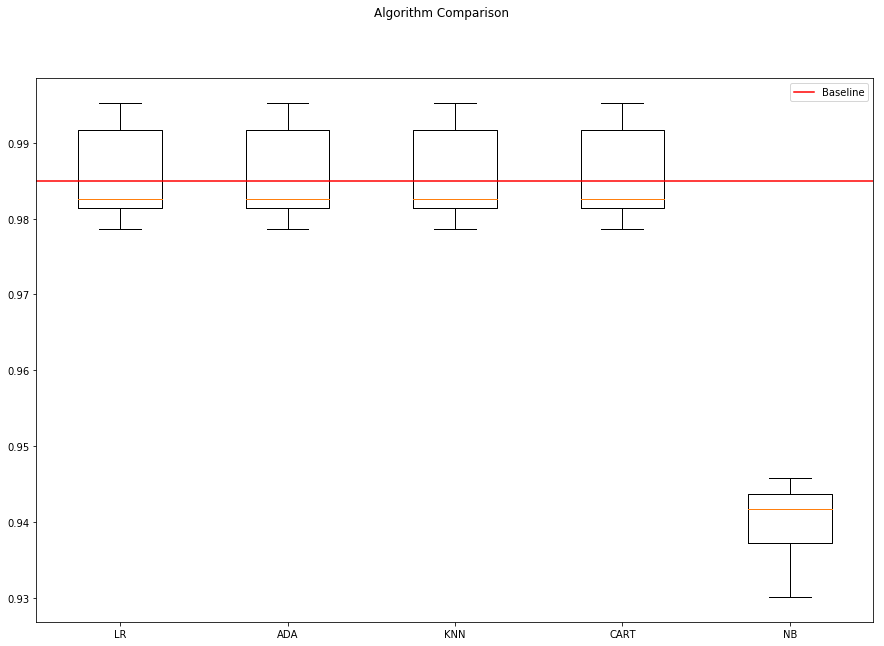

In [50]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(15,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.axhline(y=0.985, color='r', linestyle='-',label='Baseline')
plt.legend()
plt.show()

## Create ensemble voting classifier model (all features)

In [80]:
estimators = []
model1 = LogisticRegression()
estimators.append(('LR', model1))
model2 = DecisionTreeClassifier()
estimators.append(('CART', model2))
model3 = AdaBoostClassifier()
estimators.append(('ADA', model3))
model4 = KNeighborsClassifier()
estimators.append(('KNN',model4))

# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X, y, cv=kfold)
print(round(results.mean(),3))

0.986


## Create ensemble voting classifier model (only rank 1 features)

In [81]:
estimators = []
model1 = LogisticRegression()
estimators.append(('LR', model1))
model2 = DecisionTreeClassifier()
estimators.append(('CART', model2))
model3 = AdaBoostClassifier()
estimators.append(('ADA', model3))
model4 = KNeighborsClassifier()
estimators.append(('KNN',model4))

# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X2, y2, cv=kfold)
print(round(results.mean(),3))

0.986


# 6. Logisitc Regression Model

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [54]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train, y_train)
y_predict = logreg.predict_proba(X_test)
my_list = map(lambda x: x[1], y_predict)
y_pred = pd.Series(my_list).round()

In [55]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3)

In [56]:
logreg = LogisticRegression()
logreg = logreg.fit(X2_train, y2_train)
y2_predict = logreg.predict_proba(X2_test)
my_list = map(lambda x: x[1], y2_predict)
y2_pred = pd.Series(my_list).round()

## Accuracy & Confusion Matrix

In [60]:
import numpy as np
from sklearn.metrics import confusion_matrix
print('Accuracy : {:.3f}'.format(accuracy_score(y_test, y_pred)))

confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix :\n",confusion_matrix)

Accuracy : 0.986
Confusion matrix :
 [[35408     0]
 [  519     0]]


In [63]:
import numpy as np
from sklearn.metrics import confusion_matrix
print('Accuracy : {:.3f}'.format(accuracy_score(y2_test, y2_pred)))

confusion_matrix = confusion_matrix(y2_test, y2_pred)
print("Confusion matrix :\n",confusion_matrix)

Accuracy : 0.986
Confusion matrix :
 [[35413     0]
 [  514     0]]


In [64]:
tn, fp, fn, tp = confusion_matrix.ravel()

In [65]:
#Sensitivity: TP/(TP+FN)
sensitivity1 = tp/(tp+fn)
#sensitivity1 = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
print('Sensitivity : ', round(sensitivity1,3))

#Specificity: TN/(TN+FP)
specificity1 = tn/(tn+fp)
print('Specificity : ', round(specificity1,3))

Sensitivity :  0.0
Specificity :  1.0


## AUC Curve

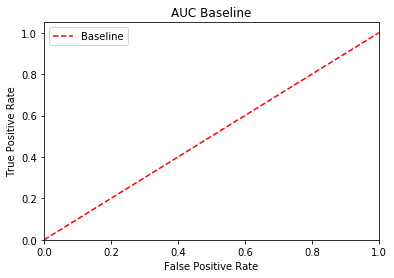

In [66]:
plt.figure()
plt.plot([0, 1], [0, 1],'r--', label="Baseline")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Baseline')
plt.legend(loc="upper left")
plt.show()

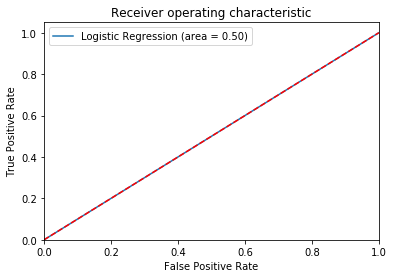

In [67]:
logit_roc_auc = roc_auc_score(y2_test, y2_pred) #pos_label='Yes')
fpr, tpr, thresholds = roc_curve(y2_test, y2_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="upper left")
plt.show()

## Precision Recall Curve

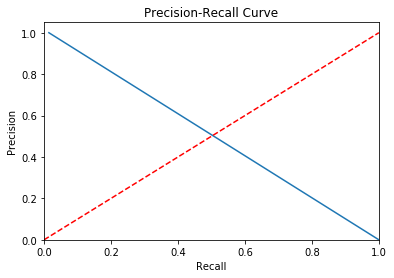

In [68]:
precision, recall, thresholds = precision_recall_curve(y2_test, y2_pred)
plt.figure()
plt.plot(precision, recall)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
#plt.legend(loc="upper left")
plt.show()

## AdaBoost Model

In [69]:
import numpy as np

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size = 0.3)

In [71]:
ada = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1, algorithm='SAMME',
                         random_state=0)
ada = ada.fit(X_train, y_train)
y_predict = ada.predict_proba(X_test)
my_list = map(lambda x: x[1], y_predict)
y_pred = pd.Series(my_list).round()

In [74]:
import numpy as np
from sklearn.metrics import confusion_matrix
print('Accuracy : {:.3f}'.format(accuracy_score(y_test, y_pred)))

confusion_matrix = confusion_matrix(y_test, y_pred)
print("Confusion matrix :\n",confusion_matrix)

Accuracy : 0.986
Confusion matrix :
 [[35427     0]
 [  500     0]]


In [75]:
tn, fp, fn, tp = confusion_matrix.ravel()

In [76]:
#Sensitivity: TP/(TP+FN)
sensitivity1 = tp/(tp+fn)
#sensitivity1 = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[0,1])
print('Sensitivity : ', round(sensitivity1,3))

#Specificity: TN/(TN+FP)
specificity1 = tn/(tn+fp)
print('Specificity : ', round(specificity1,3))

Sensitivity :  0.0
Specificity :  1.0


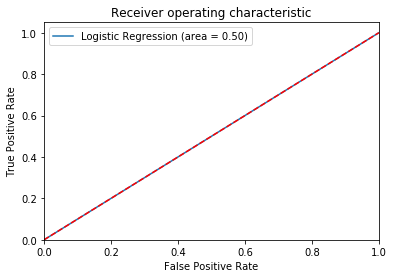

In [77]:
logit_roc_auc = roc_auc_score(y_test, y_pred) #pos_label='Yes')
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="upper left")
plt.show()

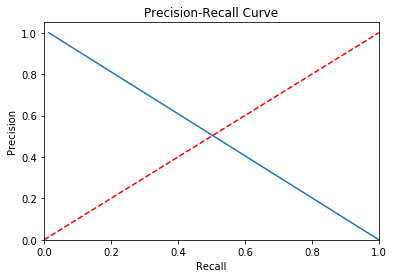

In [78]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.figure()
plt.plot(precision, recall)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
#plt.legend(loc="upper left")
plt.show()